In [ ]:
pip install shimmy>=2.0


In [9]:
!pip uninstall nltk
!pip install nltk


Found existing installation: nltk 3.9.1
Uninstalling nltk-3.9.1:
  Would remove:
    /usr/local/bin/nltk
    /usr/local/lib/python3.11/dist-packages/nltk-3.9.1.dist-info/*
    /usr/local/lib/python3.11/dist-packages/nltk/*
Proceed (Y/n)? y
  Successfully uninstalled nltk-3.9.1
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 16.3 MB/s eta 0:00:00


In [6]:
import nltk
nltk.data.clear_cache()


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


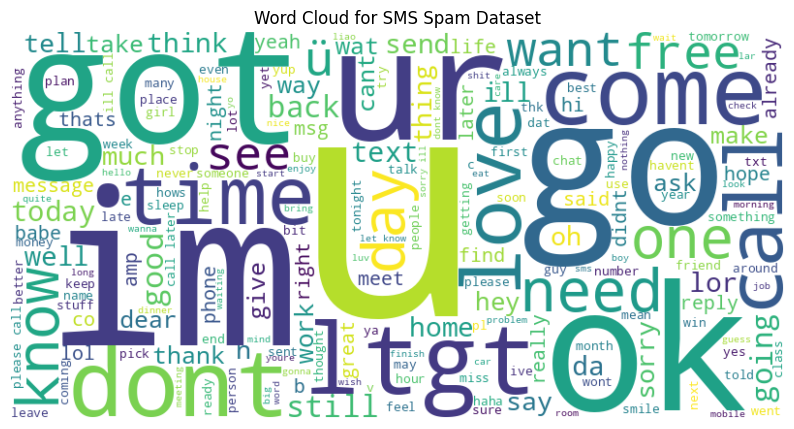

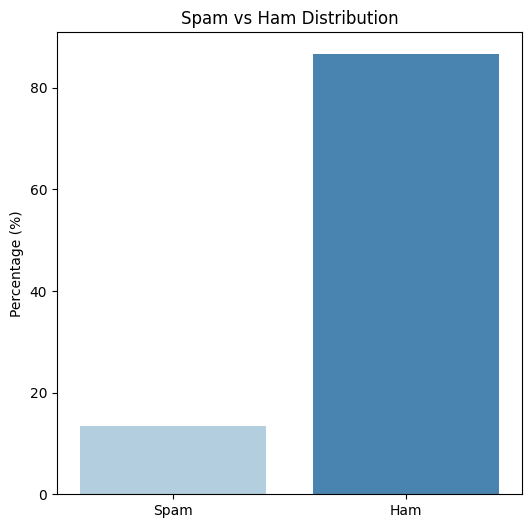

Spam messages: 747 (13.41%)
Ham messages: 4825 (86.59%)


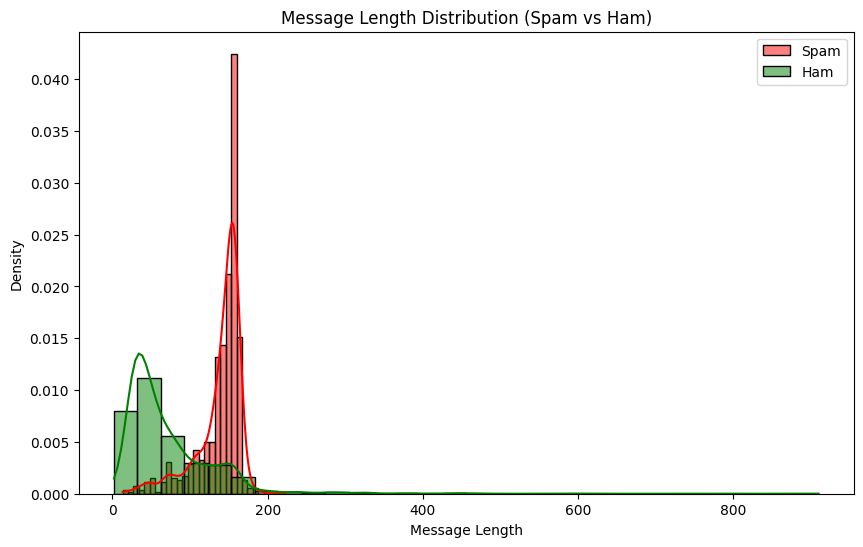

Total words in Spam messages: 10688
Total words in Ham messages: 39246


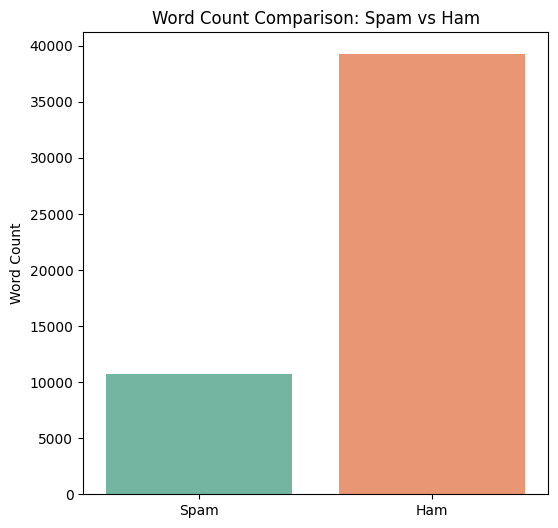

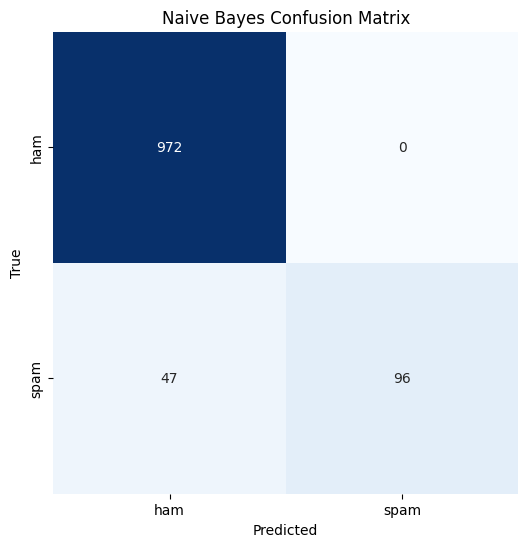

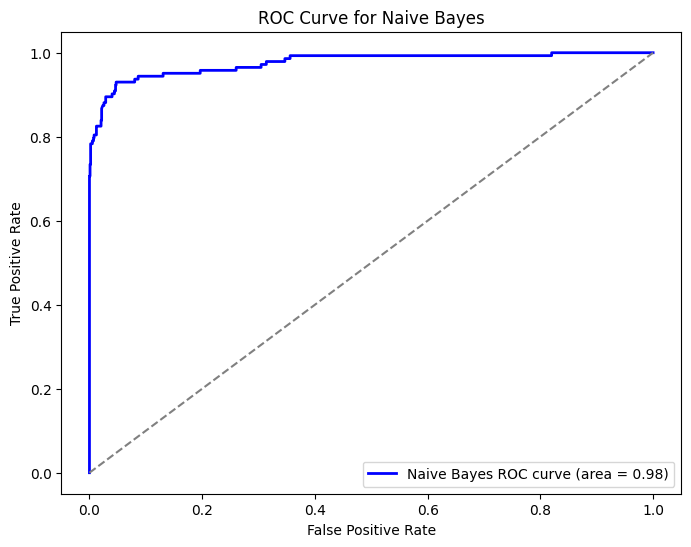

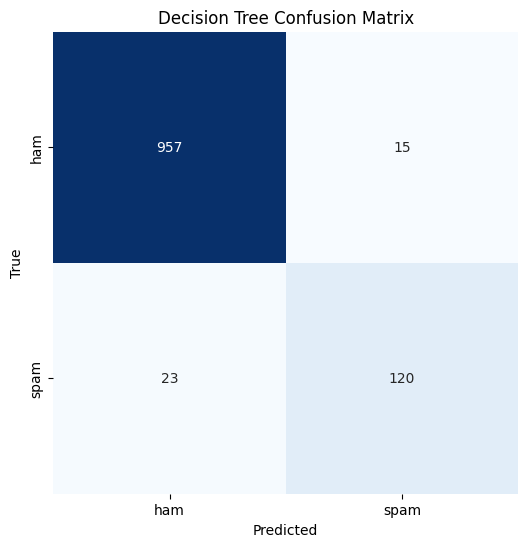

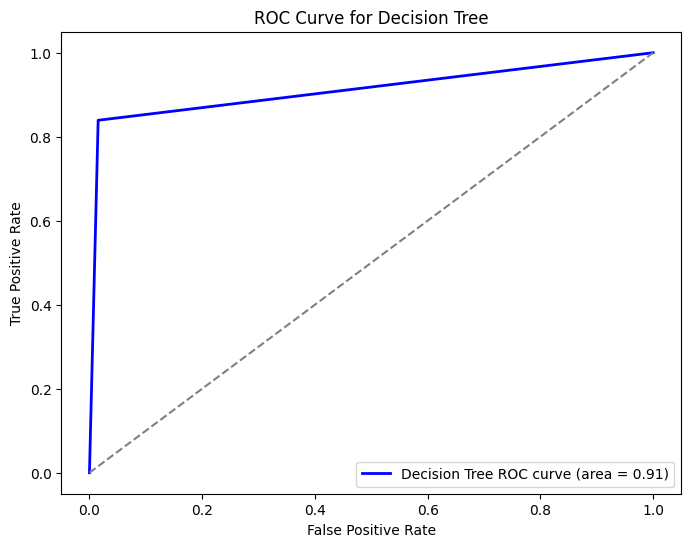

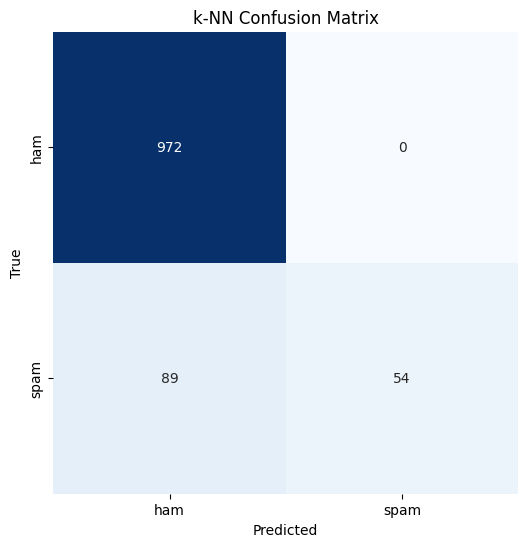

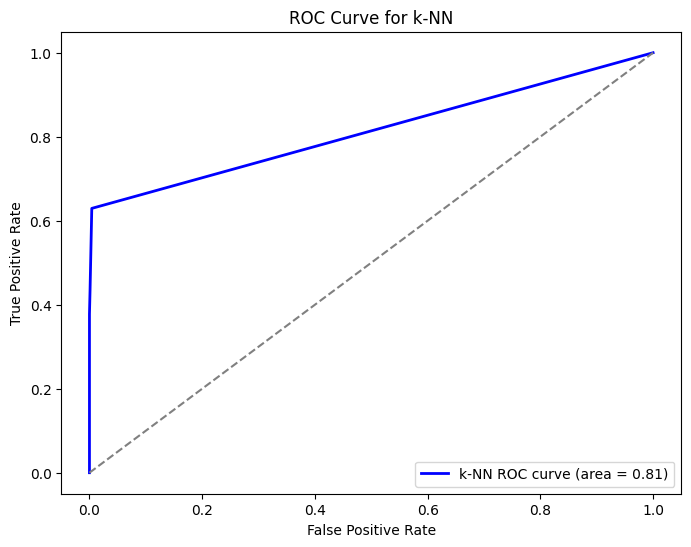

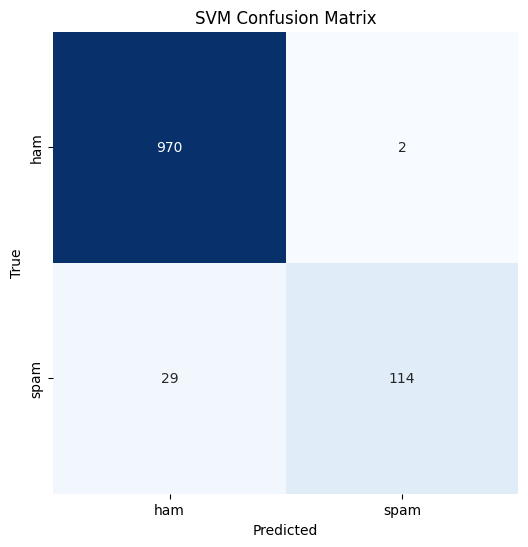

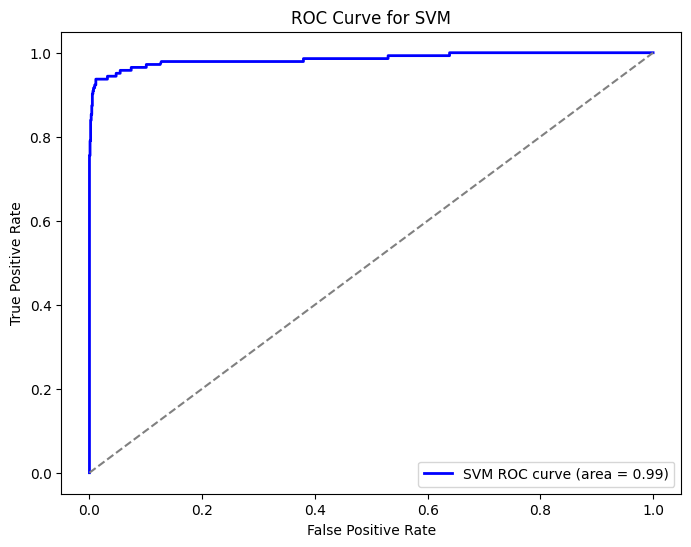

Confusion Matrix Comparison Table:
               True Negative  False Positive  False Negative  True Positive  \
Naive Bayes            972.0             0.0            47.0           96.0   
Decision Tree          957.0            15.0            23.0          120.0   
k-NN                   972.0             0.0            89.0           54.0   
SVM                    970.0             2.0            29.0          114.0   

               Accuracy  Precision    Recall  F1-Score  
Naive Bayes    0.957848   1.000000  0.671329  0.803347  
Decision Tree  0.965919   0.888889  0.839161  0.863309  
k-NN           0.920179   1.000000  0.377622  0.548223  
SVM            0.972197   0.982759  0.797203  0.880309  


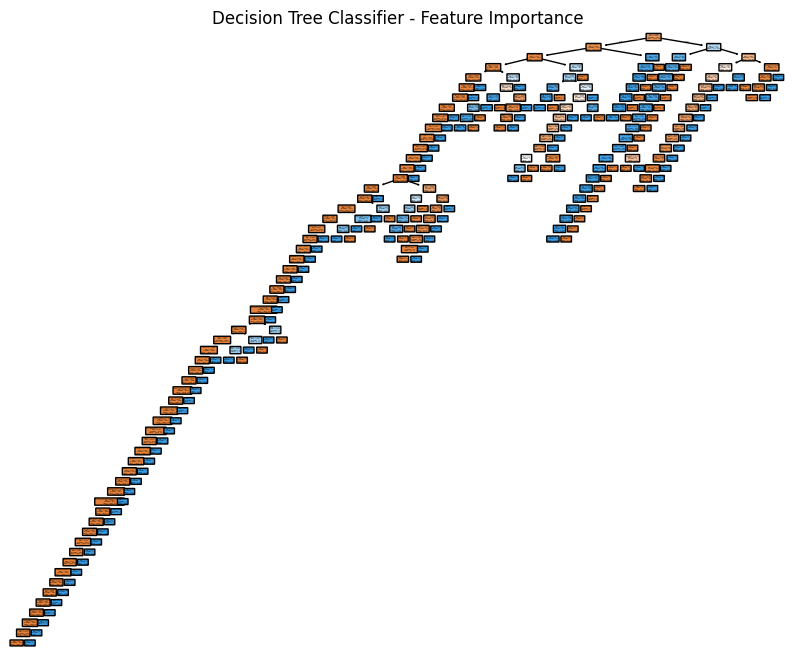

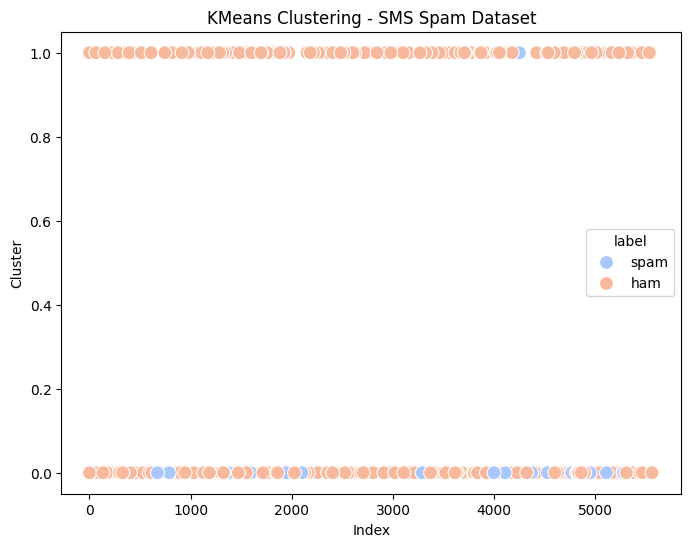

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import string
import re
import torch
import torch.nn as nn
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
import warnings

warnings.filterwarnings("ignore")
nltk.download('stopwords')

# ------------------------ 1. Load and Preprocess SMS Spam Dataset -------------------------
sms_df = pd.read_csv('SMSSpamCollection', sep='\t', names=['label', 'message'])
sms_df = shuffle(sms_df)

# Preprocessing function using regex for tokenization
def preprocess_simple(text):
    text = text.lower()
    text = re.sub(r"\d+", "", text)
    text = text.translate(str.maketrans("", "", string.punctuation))
    tokens = re.findall(r'\b\w+\b', text)  # Tokenize using regex
    tokens = [w for w in tokens if w not in stopwords.words('english')]
    return ' '.join(tokens)

sms_df['clean_text'] = sms_df['message'].apply(preprocess_simple)

# Encode labels to numerical values
le = LabelEncoder()
sms_df['label_num'] = le.fit_transform(sms_df['label'])

# ------------------------ 2. Feature Extraction -------------------------
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(sms_df['clean_text'])
y = sms_df['label_num']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ------------------------ 3. Word Cloud Generation -------------------------

def plot_word_cloud(sms_df):
    all_text = ' '.join(sms_df['clean_text'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)

    # Ensure the plot appears
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('Word Cloud for SMS Spam Dataset')
    plt.show()

# Call the function to display the word cloud
plot_word_cloud(sms_df)


# ------------------------ 4. Spam Distribution Analysis -------------------------
def analyze_spam_distribution(sms_df):
    # Count the number of spam and ham messages
    spam_count = sms_df[sms_df['label'] == 'spam'].shape[0]
    ham_count = sms_df[sms_df['label'] == 'ham'].shape[0]
    total_count = sms_df.shape[0]

    # Calculate the percentage of spam and ham messages
    spam_percentage = (spam_count / total_count) * 100
    ham_percentage = (ham_count / total_count) * 100

    # Plot the distribution using a bar plot
    plt.figure(figsize=(6, 6))
    sns.barplot(x=['Spam', 'Ham'], y=[spam_percentage, ham_percentage], palette='Blues')
    plt.title('Spam vs Ham Distribution')
    plt.ylabel('Percentage (%)')
    plt.show()

    # Print the spam and ham message counts and percentages
    print(f"Spam messages: {spam_count} ({spam_percentage:.2f}%)")
    print(f"Ham messages: {ham_count} ({ham_percentage:.2f}%)")

# Call the function to display the spam distribution analysis
analyze_spam_distribution(sms_df)


# ------------------------ 5. Message Length Distribution -------------------------
def plot_message_length_distribution(sms_df):
    # Calculate the length of each message
    sms_df['message_length'] = sms_df['message'].apply(len)

    # Separate spam and ham messages for plotting
    spam_messages = sms_df[sms_df['label'] == 'spam']['message_length']
    ham_messages = sms_df[sms_df['label'] == 'ham']['message_length']

    # Plot the message length distribution using seaborn
    plt.figure(figsize=(10, 6))
    sns.histplot(spam_messages, bins=30, kde=True, color='red', label='Spam', stat='density')
    sns.histplot(ham_messages, bins=30, kde=True, color='green', label='Ham', stat='density')

    # Add titles and labels
    plt.title('Message Length Distribution (Spam vs Ham)')
    plt.xlabel('Message Length')
    plt.ylabel('Density')
    plt.legend()
    plt.show()

# Call the function to display the message length distribution
plot_message_length_distribution(sms_df)


# ------------------------ 4. Word Count Analysis -------------------------
def word_count(sms_df):
    # Join the messages and calculate word count
    spam_words = ' '.join(sms_df[sms_df['label'] == 'spam']['clean_text'])
    ham_words = ' '.join(sms_df[sms_df['label'] == 'ham']['clean_text'])

    spam_word_count = len(spam_words.split())
    ham_word_count = len(ham_words.split())

    print(f"Total words in Spam messages: {spam_word_count}")
    print(f"Total words in Ham messages: {ham_word_count}")

    # Ensure the plot displays correctly
    plt.figure(figsize=(6, 6))
    sns.barplot(x=['Spam', 'Ham'], y=[spam_word_count, ham_word_count], palette='Set2')
    plt.title('Word Count Comparison: Spam vs Ham')
    plt.ylabel('Word Count')
    plt.show()

# Call the function to show the word count analysis
word_count(sms_df)


# ------------------------ 7. Train and Evaluate Models -------------------------
from sklearn.metrics import confusion_matrix, roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Models to evaluate
models = {
    'Naive Bayes': MultinomialNB(),
    'Decision Tree': DecisionTreeClassifier(),
    'k-NN': KNeighborsClassifier(),
    'SVM': SVC(probability=True)
}

# Initialize an empty dictionary to store confusion matrix results
cm_data = {}

# Iterate over each model
for name, model in models.items():
    # Train the model
    model.fit(X_train, y_train)

    # Predict on the test set
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]  # Probability for ROC curve

    # Generate confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # Plot confusion matrix heatmap
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title(f"{name} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

    # Calculate performance metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # Store the results in the dictionary
    cm_data[name] = {
        'True Negative': cm[0, 0],
        'False Positive': cm[0, 1],
        'False Negative': cm[1, 0],
        'True Positive': cm[1, 1],
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1
    }

    # Calculate and plot ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'{name} ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.title(f"ROC Curve for {name}")
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    plt.show()

# Convert the dictionary to a pandas DataFrame for comparison
cm_comparison_df = pd.DataFrame(cm_data).T

# Display the confusion matrix comparison table
print("Confusion Matrix Comparison Table:")
print(cm_comparison_df)


# ------------------------ 8. Decision Tree Feature Importance -------------------------
decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, y_train)
plt.figure(figsize=(10, 8))
plot_tree(decision_tree, filled=True, feature_names=vectorizer.get_feature_names_out(), class_names=le.classes_, rounded=True)
plt.title("Decision Tree Classifier - Feature Importance")
plt.show()

# ------------------------ 9. KMeans Clustering -------------------------
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(X)
sms_df['cluster'] = kmeans.labels_

plt.figure(figsize=(8, 6))
sns.scatterplot(x=sms_df.index, y=sms_df['cluster'], hue=sms_df['label'], palette="coolwarm", s=100)
plt.title("KMeans Clustering - SMS Spam Dataset")
plt.xlabel("Index")
plt.ylabel("Cluster")
plt.show()


In [5]:
!pip install "shimmy>=2.0"


              precision    recall  f1-score   support

           0       0.67      0.00      0.01      2399
           1       0.51      1.00      0.67      2478

    accuracy                           0.51      4877
   macro avg       0.59      0.50      0.34      4877
weighted avg       0.59      0.51      0.35      4877



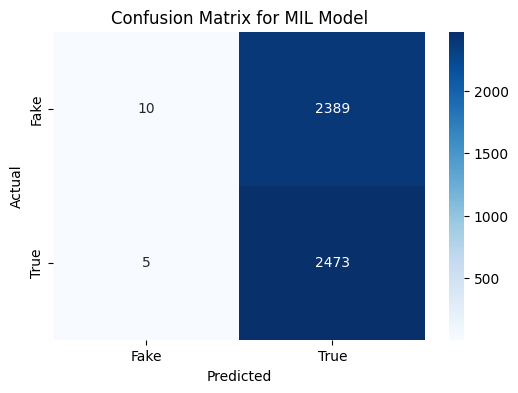

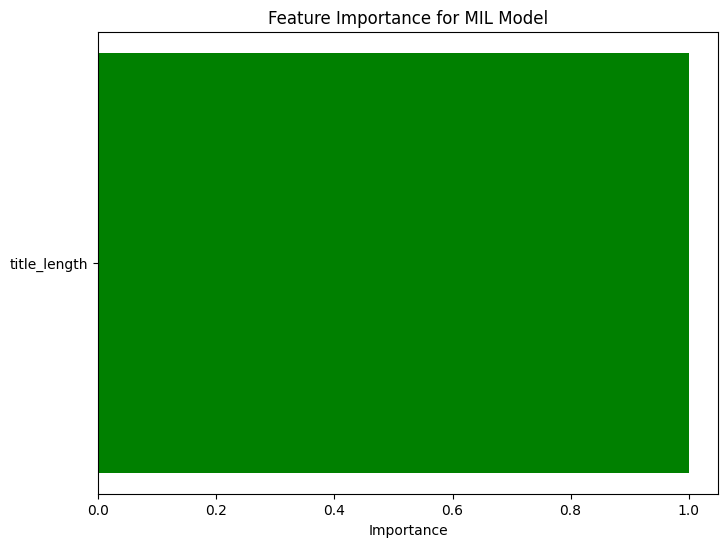

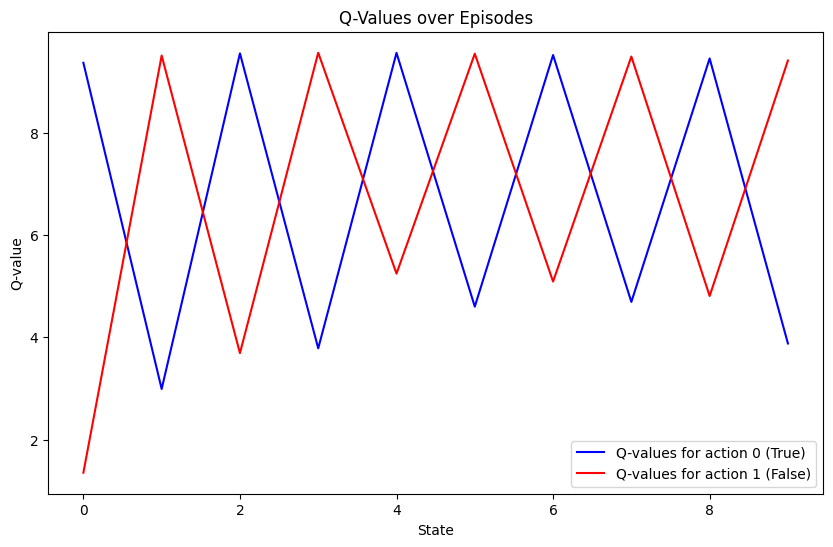

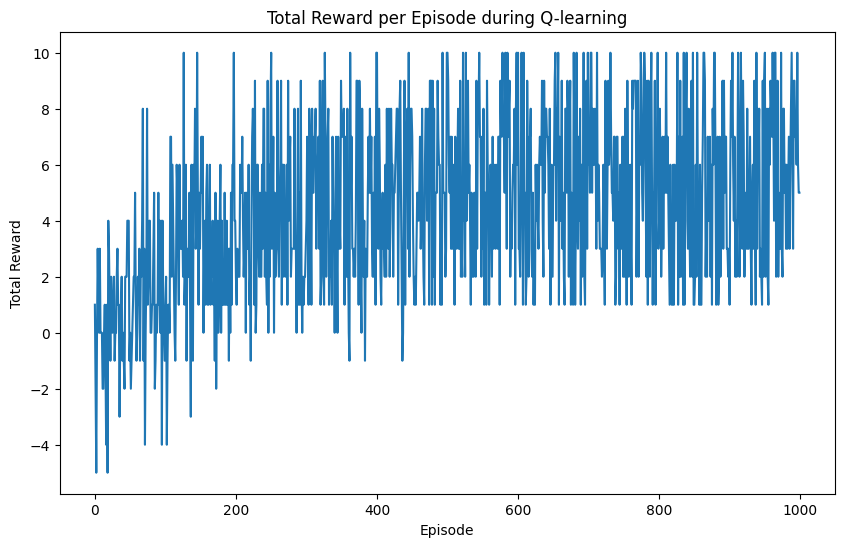

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Streaming output truncated to the last 5000 lines.
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 7.93e-05 |
|    n_updates        | 2141     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1        |
|    ep_rew_mean      | 0.9      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8672     |
|    fps              | 342      |
|    time_elapsed     | 25       |
|    total_timesteps  | 8672     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.000116 |
|    n_updates        | 2142     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1        |
|    ep_rew_mean      | 0.92     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8676     |
|   

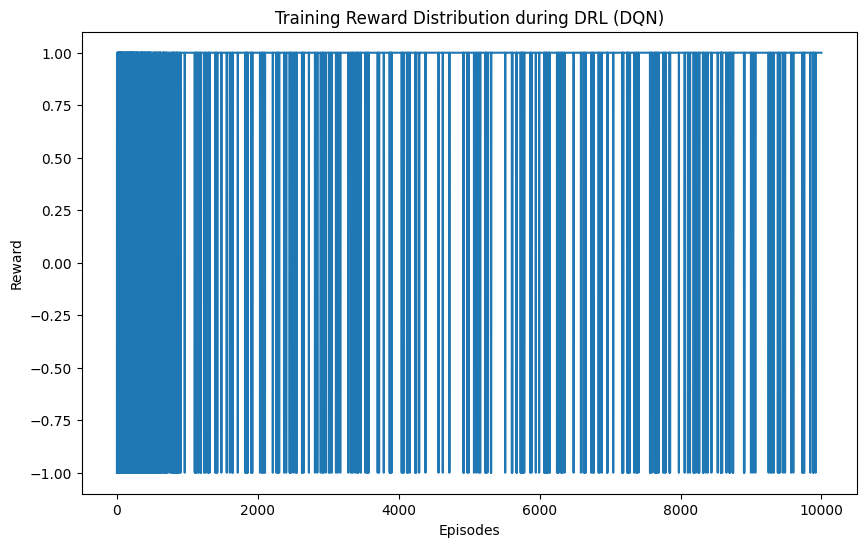

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import gym
from stable_baselines3 import DQN
from stable_baselines3.common.callbacks import BaseCallback

# Load datasets
import csv
true_news_df = pd.read_csv('True.csv', quoting=csv.QUOTE_NONE, on_bad_lines='skip')
false_news_df = pd.read_csv('Fake.csv', quoting=csv.QUOTE_NONE, on_bad_lines='skip')

# Label the datasets
true_news_df['label'] = 'True'
false_news_df['label'] = 'False'

# Combine the datasets
df = pd.concat([true_news_df[['title', 'label']], false_news_df[['title', 'label']]], ignore_index=True)

# Convert text to features (title length)
df['title_length'] = df['title'].apply(lambda x: len(str(x).split()))

# Create feature and label arrays
X = df[['title_length']]  # Feature
y = df['label'].apply(lambda x: 1 if x == 'True' else 0)  # Label

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train RandomForestClassifier
clf = RandomForestClassifier(n_estimators=100)
clf.fit(X_train, y_train)

# Predict the labels
y_pred = clf.predict(X_test)

# Print classification report
print(classification_report(y_test, y_pred))

# Confusion Matrix Visualization
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake', 'True'], yticklabels=['Fake', 'True'])
plt.title('Confusion Matrix for MIL Model')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Feature Importance Visualization
plt.figure(figsize=(8, 6))
feature_importance = clf.feature_importances_
plt.barh(X.columns, feature_importance, color='green')
plt.title('Feature Importance for MIL Model')
plt.xlabel('Importance')
plt.show()

# Parameters for Q-learning
n_actions = 2  # Two actions: True or False
n_states = 10  # Simplified state space
Q = np.zeros((n_states, n_actions))  # Initialize Q-table

# Hyperparameters for Q-learning
learning_rate = 0.1
discount_factor = 0.9
exploration_rate = 1.0
exploration_decay = 0.995
episodes = 1000
rewards_per_episode = []  # Store rewards

# Define reward function
def reward_function(action, state):
    return 1 if (state % 2 == action) else -1

# Q-learning algorithm
for episode in range(episodes):
    state = np.random.choice(n_states)  # Random initial state
    done = False
    episode_reward = 0

    while not done:
        # Exploration vs Exploitation
        if np.random.rand() < exploration_rate:
            action = np.random.choice(n_actions)  # Explore: random action
        else:
            action = np.argmax(Q[state])  # Exploit: best action based on Q-values

        # Get reward for taking action
        reward = reward_function(action, state)
        episode_reward += reward
        next_state = (state + 1) % n_states  # Transition to next state

        # Update Q-table using Q-learning rule
        Q[state, action] = Q[state, action] + learning_rate * (reward + discount_factor * np.max(Q[next_state]) - Q[state, action])

        state = next_state  # Move to next state
        if state == 0:  # End condition (when we return to initial state)
            done = True

    # Decay exploration rate
    exploration_rate *= exploration_decay
    rewards_per_episode.append(episode_reward)

# Plot Q-values over episodes
plt.figure(figsize=(10, 6))
plt.plot(Q[:, 0], label='Q-values for action 0 (True)', color='blue')
plt.plot(Q[:, 1], label='Q-values for action 1 (False)', color='red')
plt.title('Q-Values over Episodes')
plt.xlabel('State')
plt.ylabel('Q-value')
plt.legend()
plt.show()

# Plot rewards per episode
plt.figure(figsize=(10, 6))
plt.plot(rewards_per_episode)
plt.title('Total Reward per Episode during Q-learning')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.show()

# Custom environment for news classification
class NewsEnv(gym.Env):
    def __init__(self):
        super(NewsEnv, self).__init__()
        self.action_space = gym.spaces.Discrete(2)  # Two actions: True or False
        self.observation_space = gym.spaces.Box(low=0, high=1, shape=(5,), dtype=np.float32)  # Example feature space
        self.state = np.random.rand(5)  # Example initial state

    def reset(self):
        self.state = np.random.rand(5)  # Reset state
        return self.state

    def step(self, action):
        reward = 1 if action == 0 else -1  # Simplified reward
        done = True  # End after one step
        next_state = np.random.rand(5)  # Random next state
        return next_state, reward, done, {}

# Custom callback for logging rewards
class RewardLoggerCallback(BaseCallback):
    def __init__(self, verbose=0):
        super(RewardLoggerCallback, self).__init__(verbose)
        self.reward_history = []

    def _on_step(self) -> bool:
        rewards = self.locals.get('rewards', [])
        if rewards:
            self.reward_history.append(sum(rewards))  # Track reward for current episode
        return True

    def get_reward_history(self):
        return self.reward_history

# Instantiate environment and DQN agent
env = NewsEnv()
model = DQN('MlpPolicy', env, verbose=1)

# Train model with reward logging
reward_logger = RewardLoggerCallback(verbose=1)
model.learn(total_timesteps=10000, callback=reward_logger)

# Save the model
model.save("news_dqn_model")

# Get training reward history
reward_history = reward_logger.get_reward_history()

# Plot training reward distribution
plt.figure(figsize=(10, 6))
plt.plot(reward_history)
plt.title('Training Reward Distribution during DRL (DQN)')
plt.xlabel('Episodes')
plt.ylabel('Reward')
plt.show()
